# Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Configuration
base_dir = Path("/zdata/user-data/noam/data/p2cs/")
full_genomes_dir = base_dir / "full_genomes_new"

# Parse genome files (old)

In [4]:
# Load the master mapping file
mapping_file = full_genomes_dir / "chromosome_assembly_mapping.csv"
print(f"Loading mapping from: {mapping_file}")

# Load the CSV mapping file
mapping_df = pd.read_csv(mapping_file)
print(f"Loaded {len(mapping_df)} chromosome entries")
print(f"Columns: {list(mapping_df.columns)}")

# Display basic info about the mapping
print(f"\nMapping Summary:")
print(f"Unique organisms: {mapping_df['organism'].nunique()}")
print(f"Unique assemblies: {mapping_df['assembly_accession'].nunique()}")
print(f"Total chromosome files: {len(mapping_df)}")

# Show first few rows
print(f"\nFirst 5 entries:")
mapping_df.head()


Loading mapping from: /zdata/user-data/noam/data/p2cs/full_genomes_new/chromosome_assembly_mapping.csv
Loaded 133670 chromosome entries
Columns: ['filename', 'organism', 'assembly_accession', 'chromosome_name', 'file_path', 'header']

Mapping Summary:
Unique organisms: 2131
Unique assemblies: 5637
Total chromosome files: 133670

First 5 entries:


,filename,organism,assembly_accession,chromosome_name,file_path,header
0,Actinobacillus_succinogenes_130Z_GCF_000017245...,Actinobacillus succinogenes 130Z,GCF_000017245.1,NC_009655.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,"NC_009655.1 Actinobacillus succinogenes 130Z, ..."
1,Actinobacillus_succinogenes_130Z_GCA_000017245...,Actinobacillus succinogenes 130Z,GCA_000017245.1,CP000746.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,"CP000746.1 Actinobacillus succinogenes 130Z, c..."
2,Burkholderia_ambifaria_MC40-6_GCF_000019925.1_...,Burkholderia ambifaria MC40-6,GCF_000019925.1,NC_010551.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,NC_010551.1 Burkholderia ambifaria MC40-6 chro...
3,Burkholderia_ambifaria_MC40-6_GCF_000019925.1_...,Burkholderia ambifaria MC40-6,GCF_000019925.1,NC_010552.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,NC_010552.1 Burkholderia ambifaria MC40-6 chro...
4,Burkholderia_ambifaria_MC40-6_GCF_000019925.1_...,Burkholderia ambifaria MC40-6,GCF_000019925.1,NC_010557.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,NC_010557.1 Burkholderia ambifaria MC40-6 chro...


In [6]:
# Function to calculate nucleotide length from FASTA file
def calculate_fasta_length(file_path):
    """Calculate the total nucleotide length of a FASTA file."""
    try:
        total_length = 0
        with open(file_path, 'r') as f:
            for line in f:
                if not line.startswith('>'):
                    total_length += len(line.strip())
        return total_length
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return 0

# Calculate lengths for all chromosome files
print("Calculating nucleotide lengths for all chromosome files...")
print("This may take a while depending on the number of files...")

# Add length column to mapping dataframe
mapping_df['nucleotide_length'] = 0

# Process files in batches to show progress
batch_size = 1000
total_files = len(mapping_df)
processed = 0

for i in range(0, total_files, batch_size):
    batch_end = min(i + batch_size, total_files)
    batch_df = mapping_df.iloc[i:batch_end]
    
    print(f"Processing files {i+1}-{batch_end} of {total_files}...")
    
    for idx, row in batch_df.iterrows():
        file_path = Path(row['file_path'])
        if file_path.exists():
            length = calculate_fasta_length(file_path)
            mapping_df.at[idx, 'nucleotide_length'] = length
        else:
            mapping_df.at[idx, 'nucleotide_length'] = 0
    
    processed = batch_end
    print(f"Completed {processed}/{total_files} files")

print(f"\nLength calculation completed!")
print(f"Files with length > 0: {(mapping_df['nucleotide_length'] > 0).sum()}")
print(f"Files with length = 0: {(mapping_df['nucleotide_length'] == 0).sum()}")


Calculating nucleotide lengths for all chromosome files...
This may take a while depending on the number of files...
Processing files 1-1000 of 133670...
Completed 1000/133670 files
Processing files 1001-2000 of 133670...
Completed 2000/133670 files
Processing files 2001-3000 of 133670...
Completed 3000/133670 files
Processing files 3001-4000 of 133670...
Completed 4000/133670 files
Processing files 4001-5000 of 133670...
Completed 5000/133670 files
Processing files 5001-6000 of 133670...
Completed 6000/133670 files
Processing files 6001-7000 of 133670...
Completed 7000/133670 files
Processing files 7001-8000 of 133670...
Completed 8000/133670 files
Processing files 8001-9000 of 133670...
Completed 9000/133670 files
Processing files 9001-10000 of 133670...
Completed 10000/133670 files
Processing files 10001-11000 of 133670...
Completed 11000/133670 files
Processing files 11001-12000 of 133670...
Completed 12000/133670 files
Processing files 12001-13000 of 133670...
Completed 13000/1336

In [7]:
# Analyze the length data
print("=== NUCLEOTIDE LENGTH ANALYSIS ===")

# Basic statistics
lengths = mapping_df['nucleotide_length']
print(f"\nLength Statistics:")
print(f"Total files: {len(lengths)}")
print(f"Files with data: {(lengths > 0).sum()}")
print(f"Files missing: {(lengths == 0).sum()}")
print(f"Mean length: {lengths[lengths > 0].mean():,.0f} bp")
print(f"Median length: {lengths[lengths > 0].median():,.0f} bp")
print(f"Min length: {lengths[lengths > 0].min():,.0f} bp")
print(f"Max length: {lengths[lengths > 0].max():,.0f} bp")

# Length distribution by organism
print(f"\nTop 10 organisms by total genome length:")
organism_lengths = mapping_df.groupby('organism')['nucleotide_length'].sum().sort_values(ascending=False)
print(organism_lengths.head(10))

# Length distribution by assembly
print(f"\nTop 10 assemblies by total genome length:")
assembly_lengths = mapping_df.groupby('assembly_accession')['nucleotide_length'].sum().sort_values(ascending=False)
print(assembly_lengths.head(10))

# Show some examples with lengths
print(f"\nExample entries with lengths:")
sample_with_lengths = mapping_df[['organism', 'assembly_accession', 'chromosome_name', 'nucleotide_length']].head(10)
print(sample_with_lengths.to_string(index=False))


=== NUCLEOTIDE LENGTH ANALYSIS ===

Length Statistics:
Total files: 133670
Files with data: 133670
Files missing: 0
Mean length: 161,387 bp
Median length: 4,531 bp
Min length: 20 bp
Max length: 14,782,125 bp

Top 10 organisms by total genome length:
organism
Burkholderia sp. 383                     84374500
Paenibacillus sp. Y412MC10               74015700
Pseudomonas sp. TKP                      71305030
Streptomyces avermitilis MA-4680         69754415
Pseudomonas fluorescens F113             67574535
Vibrio nigripulchritudo                  65095264
Frankia symbiont of Datisca glomerata    64322056
Pseudomonas aeruginosa PAO1              62739444
Azospirillum brasilense Sp245            60035678
Agrobacterium sp. H13-3                  57835582
Name: nucleotide_length, dtype: int64

Top 10 assemblies by total genome length:
assembly_accession
GCA_000010845.1    20038014
GCF_000010845.1    20038014
GCF_000418325.1    14782125
GCA_000418325.1    14782125
GCF_048541595.1    14251041
G

In [8]:
# Save the updated mapping with nucleotide lengths
print("=== SAVING UPDATED MAPPING ===")

# Save updated CSV
updated_mapping_file = full_genomes_dir / "chromosome_assembly_mapping_with_lengths.csv"
mapping_df.to_csv(updated_mapping_file, index=False)
print(f"Saved updated mapping to: {updated_mapping_file}")

# Also save as JSON for easier loading later
json_mapping_file = full_genomes_dir / "chromosome_assembly_mapping_with_lengths.json"
mapping_df.to_json(json_mapping_file, orient='records', indent=2)
print(f"Saved JSON mapping to: {json_mapping_file}")

# Create a summary file with key statistics
summary_stats = {
    'total_files': len(mapping_df),
    'files_with_data': int((mapping_df['nucleotide_length'] > 0).sum()),
    'files_missing': int((mapping_df['nucleotide_length'] == 0).sum()),
    'unique_organisms': int(mapping_df['organism'].nunique()),
    'unique_assemblies': int(mapping_df['assembly_accession'].nunique()),
    'total_genome_length': int(mapping_df['nucleotide_length'].sum()),
    'mean_chromosome_length': float(mapping_df[mapping_df['nucleotide_length'] > 0]['nucleotide_length'].mean()),
    'median_chromosome_length': float(mapping_df[mapping_df['nucleotide_length'] > 0]['nucleotide_length'].median())
}

import json
summary_file = full_genomes_dir / "mapping_summary.json"
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"Saved summary statistics to: {summary_file}")

print(f"\nSummary:")
for key, value in summary_stats.items():
    if isinstance(value, int):
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value:,.2f}")

print(f"\nUpdated mapping now includes nucleotide lengths for all chromosome files!")

=== SAVING UPDATED MAPPING ===
Saved updated mapping to: /zdata/user-data/noam/data/p2cs/full_genomes_new/chromosome_assembly_mapping_with_lengths.csv
Saved JSON mapping to: /zdata/user-data/noam/data/p2cs/full_genomes_new/chromosome_assembly_mapping_with_lengths.json
Saved summary statistics to: /zdata/user-data/noam/data/p2cs/full_genomes_new/mapping_summary.json

Summary:
total_files: 133,670
files_with_data: 133,670
files_missing: 0
unique_organisms: 2,131
unique_assemblies: 5,637
total_genome_length: 21,572,534,773
mean_chromosome_length: 161,386.51
median_chromosome_length: 4,531.00

Updated mapping now includes nucleotide lengths for all chromosome files!


# Load Data

In [3]:
file_mapping = pd.read_csv(full_genomes_dir / "chromosome_assembly_mapping_with_lengths.csv")

# Choose Assembly for Organism

In [4]:
# Group by organism and assembly, and calculate average file (chromosome) length per assembly
assembly_avg_lengths = (
    file_mapping.groupby(['organism', 'assembly_accession'])['nucleotide_length']
    .mean()
    .reset_index()
    .rename(columns={'nucleotide_length': 'avg_file_length_nt'})
)

# For each organism, pick the assembly with highest average chromosome length
idx = (
    assembly_avg_lengths
    .groupby('organism')['avg_file_length_nt']
    .idxmax()
)
best_assemblies = assembly_avg_lengths.loc[idx].reset_index(drop=True)

# Also, filter file_mapping to only include the selected best assemblies per organism
selected_assemblies = set(zip(best_assemblies['organism'], best_assemblies['assembly_accession']))
file_mapping_best = file_mapping[
    file_mapping.set_index(['organism', 'assembly_accession']).index.isin(selected_assemblies)
].reset_index(drop=True)

In [5]:
file_mapping_best.head()

,filename,organism,assembly_accession,chromosome_name,file_path,header,nucleotide_length
0,Actinobacillus_succinogenes_130Z_GCA_000017245...,Actinobacillus succinogenes 130Z,GCA_000017245.1,CP000746.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,"CP000746.1 Actinobacillus succinogenes 130Z, c...",2319663
1,Burkholderia_ambifaria_MC40-6_GCA_000019925.1_...,Burkholderia ambifaria MC40-6,GCA_000019925.1,CP001025.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,CP001025.1 Burkholderia ambifaria MC40-6 chrom...,3443583
2,Burkholderia_ambifaria_MC40-6_GCA_000019925.1_...,Burkholderia ambifaria MC40-6,GCA_000019925.1,CP001026.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,CP001026.1 Burkholderia ambifaria MC40-6 chrom...,2769414
3,Burkholderia_ambifaria_MC40-6_GCA_000019925.1_...,Burkholderia ambifaria MC40-6,GCA_000019925.1,CP001027.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,CP001027.1 Burkholderia ambifaria MC40-6 chrom...,1127947
4,Burkholderia_ambifaria_MC40-6_GCA_000019925.1_...,Burkholderia ambifaria MC40-6,GCA_000019925.1,CP001028.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,CP001028.1 Burkholderia ambifaria MC40-6 plasm...,301592


In [6]:
mag_files = file_mapping_best[file_mapping_best['header'].str.contains('shotgun', na=False) | file_mapping_best['header'].str.contains('MAG', na=False)]
mag_files

,filename,organism,assembly_accession,chromosome_name,file_path,header,nucleotide_length
14,Campylobacter_jejuni_subsp._jejuni_81-176_GCA_...,Campylobacter jejuni subsp. jejuni 81-176,GCA_000168755.1,AASL01000001.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,AASL01000001.1 Campylobacter jejuni subsp. jej...,1616175
157,Pseudomonas_stutzeri_ATCC_17588_=_LMG_11199_GC...,Pseudomonas stutzeri ATCC 17588 = LMG 11199,GCA_004359495.1,RHHC01000001.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,RHHC01000001.1 Stutzerimonas stutzeri ATCC 175...,981462
158,Pseudomonas_stutzeri_ATCC_17588_=_LMG_11199_GC...,Pseudomonas stutzeri ATCC 17588 = LMG 11199,GCA_004359495.1,RHHC01000002.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,RHHC01000002.1 Stutzerimonas stutzeri ATCC 175...,970488
159,Pseudomonas_stutzeri_ATCC_17588_=_LMG_11199_GC...,Pseudomonas stutzeri ATCC 17588 = LMG 11199,GCA_004359495.1,RHHC01000003.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,RHHC01000003.1 Stutzerimonas stutzeri ATCC 175...,887677
160,Pseudomonas_stutzeri_ATCC_17588_=_LMG_11199_GC...,Pseudomonas stutzeri ATCC 17588 = LMG 11199,GCA_004359495.1,RHHC01000004.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,RHHC01000004.1 Stutzerimonas stutzeri ATCC 175...,750677
...,...,...,...,...,...,...,...
4354,Brucella_melitensis_M5-90_GCA_000348645.1_AONT...,Brucella melitensis M5-90,GCA_000348645.1,AONT01000089.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,AONT01000089.1 Brucella melitensis M5 Contig93...,1865
4355,Brucella_melitensis_M5-90_GCA_000348645.1_AONT...,Brucella melitensis M5-90,GCA_000348645.1,AONT01000090.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,AONT01000090.1 Brucella melitensis M5 Contig94...,1638
4356,Brucella_melitensis_M5-90_GCA_000348645.1_AONT...,Brucella melitensis M5-90,GCA_000348645.1,AONT01000091.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,AONT01000091.1 Brucella melitensis M5 Contig95...,1218
4478,Enterococcus_hirae_ATCC_9790_GCA_905186115.1_L...,Enterococcus hirae ATCC 9790,GCA_905186115.1,LR994474.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...,LR994474.1 Enterococcus hirae ATCC 9790 isolat...,2780723


# Plot

## Histograms

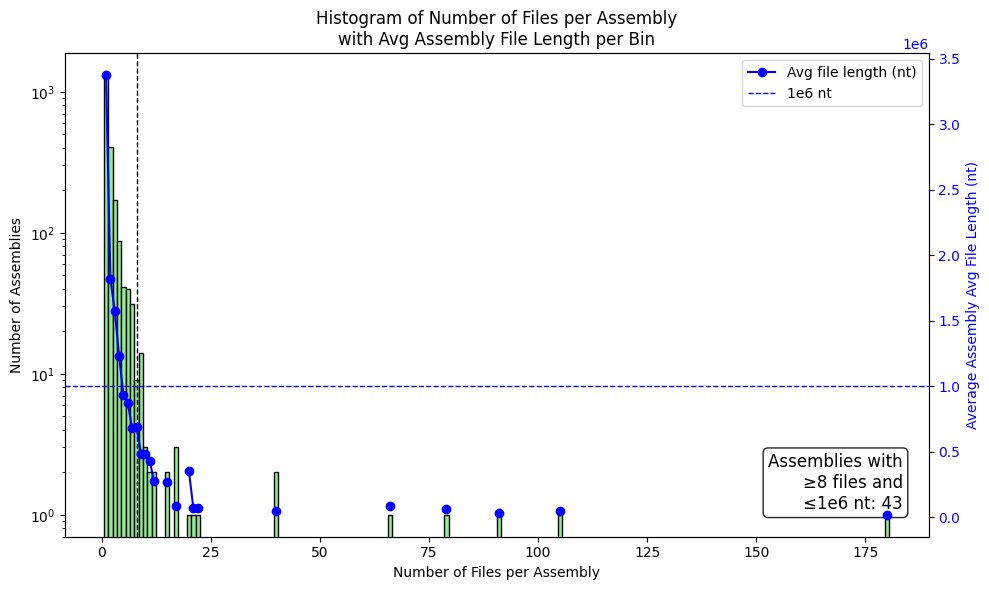

In [27]:
# Plot histogram of number of files per assembly
files_per_assembly = file_mapping_best.groupby(['organism', 'assembly_accession']).size().reset_index(name='file_count')
# Add avg_file_length_nt from best_assemblies DataFrame
files_per_assembly = files_per_assembly.merge(
    best_assemblies[['organism', 'assembly_accession', 'avg_file_length_nt']],
    on=['organism', 'assembly_accession'],
    how='left'
)

bin_edges = np.arange(1, files_per_assembly['file_count'].max()+2)
plt.figure(figsize=(10,6))

# Plot histogram (with log y scale)
counts, _, _ = plt.hist(
    files_per_assembly['file_count'],
    bins=bin_edges,
    color='lightgreen',
    edgecolor='black',
    align='left',
    label='Assemblies',
    log=True  # Set log scale for y-axis
)

# For each bin, show average assembly avg file length nt for those assemblies
bin_centers = bin_edges[:-1]
avg_lengths = []
for i in range(len(bin_edges)-1):
    in_bin = (files_per_assembly['file_count'] >= bin_edges[i]) & (files_per_assembly['file_count'] < bin_edges[i+1])
    selected_lengths = files_per_assembly.loc[in_bin, 'avg_file_length_nt']
    avg_length = selected_lengths.mean() if not selected_lengths.empty else np.nan
    avg_lengths.append(avg_length)

# Plot the average assembly avg file length nt on a secondary axis
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(bin_centers, avg_lengths, 'o-', color='blue', label='Avg file length (nt)')
# Plot a horizontal line for avg file length of 1e6
ax2.axhline(1e6, color='blue', linestyle='--', label='1e6 nt', linewidth=1)
ax2.set_ylabel('Average Assembly Avg File Length (nt)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.axvline(8, color='black', linestyle='--', label='10 files', linewidth=1)
ax1.set_xlabel('Number of Files per Assembly')
ax1.set_ylabel('Number of Assemblies')
ax1.set_title('Histogram of Number of Files per Assembly\nwith Avg Assembly File Length per Bin')
ax2.legend(loc='upper right')
plt.tight_layout()

# --- Annotation for assemblies with avg file length <= 1e6 and files >= 8 ---
n_selected = files_per_assembly[
    (files_per_assembly['avg_file_length_nt'] <= 1e6) & (files_per_assembly['file_count'] >= 8)
].shape[0]
annotation_text = f"Assemblies with\n≥8 files and\n≤1e6 nt: {n_selected}"

# Determine where to place in bottom right quarter of plot
# Use axis coordinates for placement; (1, 0) is bottom right in axes fraction
# Offset a bit upwards and to the left
ax1.annotate(
    annotation_text,
    xy=(0.97, 0.05),
    xycoords='axes fraction',
    fontsize=12,
    ha='right',
    va='bottom',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85)
)

plt.show()


In [30]:
# Look at the file headers for one assembly with 8 files, for inspection

# Find an assembly accession with 8 files
example_assembly = files_per_assembly[files_per_assembly['file_count'] == 9].head(1)
if not example_assembly.empty:
    assembly_accession = example_assembly['assembly_accession'].values[0]
    print(f"Example assembly with 8 files: {assembly_accession}")

    # Get rows in mapping_df for this assembly
    assembly_files = file_mapping_best[file_mapping_best['assembly_accession'] == assembly_accession]

    # Show the filenames
    print("\nFilenames for this assembly:")
    display(assembly_files[['filename', 'chromosome_name', 'file_path']])

    # Look at the headers for each file
    print("\nFASTA headers in these 8 files:")
    for fp in assembly_files['file_path']:
        print(f"\nFile: {fp}")
        try:
            with open(fp, 'r') as f:
                # Print all header lines (lines that start with '>')
                for line in f:
                    if line.startswith('>'):
                        print(line.strip())
        except Exception as e:
            print(f"  Error reading file: {e}")
else:
    print("No assembly found with exactly 8 files in this dataset.")


Example assembly with 8 files: GCA_000016725.1

Filenames for this assembly:


,filename,chromosome_name,file_path
2545,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000697.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2546,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000689.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2547,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000690.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2548,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000691.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2549,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000692.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2550,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000693.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2551,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000694.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2552,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000695.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...
2553,Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP00...,CP000696.1,/zdata/user-data/noam/data/p2cs/full_genomes_n...



FASTA headers in these 8 files:

File: /zdata/user-data/noam/data/p2cs/full_genomes_new/Acidiphilium_cryptum_JF-5/Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP000697.1.fasta
>CP000697.1 Acidiphilium cryptum JF-5, complete genome

File: /zdata/user-data/noam/data/p2cs/full_genomes_new/Acidiphilium_cryptum_JF-5/Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP000689.1.fasta
>CP000689.1 Acidiphilium cryptum JF-5 plasmid pACRY01, complete sequence

File: /zdata/user-data/noam/data/p2cs/full_genomes_new/Acidiphilium_cryptum_JF-5/Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP000690.1.fasta
>CP000690.1 Acidiphilium cryptum JF-5 plasmid pACRY02, complete sequence

File: /zdata/user-data/noam/data/p2cs/full_genomes_new/Acidiphilium_cryptum_JF-5/Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP000691.1.fasta
>CP000691.1 Acidiphilium cryptum JF-5 plasmid pACRY03, complete sequence

File: /zdata/user-data/noam/data/p2cs/full_genomes_new/Acidiphilium_cryptum_JF-5/Acidiphilium_cryptum_JF-5_GCA_000016725.1_CP000